In [1]:
import os
import sys
project_path = os.path.abspath('../')
sys.path.append(project_path)
import geopandas as gpd
from matplotlib import pyplot as plt
from ptac import accessibility as accessibility
from ptac import osm as osm
from ptac import population as population

Load stops and population data and generate boundary from population data.
The boundary is necessary to download the network afterwards.

In [2]:
stops = gpd.read_file(project_path + "/data/pt_example.gpkg")
population_points = gpd.read_file(project_path + "/data/population_example.gpkg")
boundary_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[population_points.unary_union.convex_hull])

if you have population data in a raster format you might want to convert this raster to a point geodataframe from
which you can start the accessibility calculation

In [3]:
population_points = population.raster_to_points(path=project_path + "/data/friedrichshain_raster.tif")

We can divide pt dataset into high and low capacity

In [4]:
stops_low_capacity = stops[stops["highway"]=="bus_stop"]
stops_high_capacity = stops[(stops["railway"]=="tram_stop")|(stops["railway"]=="station")]


It is also possible to download the network before calculating

In [5]:
network_gdf = osm.get_network(boundary_gdf)

Then, we can have a look at the network ..

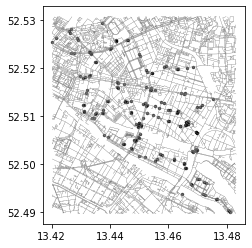

In [6]:
ax = stops.plot(color="black", markersize=6, alpha=0.6)
network_gdf.plot(color="grey", linewidth=0.2, ax=ax)
plt.show()

.. and store it to disk. You are able to drag and drop this data set into your GIS software.

In [7]:
network_gdf.to_file(project_path + "/data/friedrichshain_network.gpkg", driver="GPKG")

Now, we can calculate accessiblities for high and low capacity public transport with our stored network

In [8]:
network_gdf = gpd.read_file(project_path + "/data/friedrichshain_network.gpkg")

accessibility_output_low = accessibility.distance_to_closest(start_geometries=population_points,
                                  destination_geometries=stops_low_capacity,
                                  transport_system="low-capacity",
                                  boundary_geometries=boundary_gdf,
                                  network_gdf=network_gdf,
                                  verbose=5)


accessibility_output_high= accessibility.distance_to_closest(start_geometries=population_points,
                                  destination_geometries=stops_high_capacity,
                                  transport_system="high-capacity",
                                  boundary_geometries=boundary_gdf,
                                  network_gdf=network_gdf,
                                  verbose=5)

Street network provided

Preparing street network for routing
Starting UrMoAC to calculate accessibilities

UrMoAC request: java -jar -Xmx12g C:\Simon\git\PtAC\ptac/UrMoAccessibilityComputer-0.1-PRERELEASE-shaded.jar --from file;"C:\Users\niel_sm/.ptac/origins.csv" --shortest --to file;"C:\Users\niel_sm/.ptac/destinations.csv" --mode foot --time 35580 --epsg 32633 --ext-nm-output "file;C:\Users\niel_sm/.ptac/sdg_output.csv" --verbose --threads 1 --dropprevious --date 20200915 --net "file;C:\Users\niel_sm/.ptac/network.csv"

calculation finished in 26.540562899999998 seconds
Street network provided

Preparing street network for routing
Starting UrMoAC to calculate accessibilities

UrMoAC request: java -jar -Xmx12g C:\Simon\git\PtAC\ptac/UrMoAccessibilityComputer-0.1-PRERELEASE-shaded.jar --from file;"C:\Users\niel_sm/.ptac/origins.csv" --shortest --to file;"C:\Users\niel_sm/.ptac/destinations.csv" --mode foot --time 35580 --epsg 32633 --ext-nm-output "file;C:\Users\niel_sm/.ptac/sdg_out

.. and calculate the actual SDG indicator out of that

In [9]:
sdg_low_high = accessibility.calculate_sdg(df_pop_total=population_points,
                                           pop_accessible=[accessibility_output_high, accessibility_output_low],
                                           population_column='pop')
print(f"{sdg_low_high} percent of the population have access to low- and high-capacity public transit systems")



SDG 11.2.1 indicator is calculated
0.9856014847755432 percent of the population have access to low- and high-capacity public transit systems
